In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import plotly.io as pio

pio.renderers.default = "notebook_connected" # will supposedly render nbviewer
%config InlineBackend.figure_format = 'retina' 

## Token flow analysis

This notebook explores token flow from a network perspective. Nodes in the Filecoin transaction network are partitioned in principal component space by using network importance measures. 

Here we use PCA decomposition with all the information that we have, including value transferred and network information. 

### 0. Load data

In [2]:
df = pd.read_csv('../data/spk_trancation_detail_res.csv', index_col=[0])#.sample(2000000)

In [3]:
edgelist = df[['from_id', 'to_id', 'value']]
G = nx.from_pandas_edgelist(edgelist, 'from_id', 'to_id', 'value', create_using=nx.DiGraph)
print("Populated network")
num_neighs = {g[0]:len(g[1]) for g in G.adjacency()}
print('1 of 6 / Calculated number of neighbors')
centrality = nx.degree_centrality(G)
print('2 of 6 / Calculated centrality')
in_centrality = nx.in_degree_centrality(G)
print('3 of 6 / Calculated in-centrality')
out_centrality = nx.out_degree_centrality(G)
print('4 of 6 / Calculated out-centrality')
avg_neigh_degree = nx.average_neighbor_degree(G)
print('5 of 6 / Calculated neighbor degree')
pagerank = nx.pagerank(G)
print('6 of 6 / PageRank')

df_num_neighs = pd.DataFrame.from_dict(num_neighs, orient='index', columns=['num_neighs'])
df_centrality = pd.DataFrame.from_dict(centrality, orient='index', columns=['centrality'])
df_in_centrality = pd.DataFrame.from_dict(in_centrality, orient='index', columns=['in_centrality'])
df_out_centrality = pd.DataFrame.from_dict(out_centrality, orient='index', columns=['out_centrality'])
df_avg_neigh_degree = pd.DataFrame.from_dict(avg_neigh_degree, orient='index', columns=['avg_neigh_degree'])
df_pagerank = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])

Populated network
1 of 6 / Calculated number of neighbors
2 of 6 / Calculated centrality
3 of 6 / Calculated in-centrality
4 of 6 / Calculated out-centrality
5 of 6 / Calculated neighbor degree
6 of 6 / PageRank


The choice of metrics is predominantly driven by computation time. Certainly there are other network measures that can be considered but these are the quickest to compute. On my machine it takes a few minutes to calculate even for about 3 million nodes. 

In [4]:
dataframe = df_num_neighs\
    .merge(df_centrality, left_index=True, right_index=True)\
    .merge(df_in_centrality, left_index=True, right_index=True)\
    .merge(df_out_centrality, left_index=True, right_index=True)\
    .merge(df_avg_neigh_degree, left_index=True, right_index=True)\
    .merge(df_pagerank, left_index=True, right_index=True)

dataframe = dataframe.join(df.groupby('from_id').sum()['value'], how='left').fillna(0)
dataframe.rename(columns={'value': 'value_spent'}, inplace=True)
dataframe = dataframe.join(df.groupby('to_id').sum()['value'], how='left').fillna(0)    
dataframe.rename(columns={'value': 'value_received'}, inplace=True)

In [5]:
pipeline = make_pipeline(PowerTransformer(), StandardScaler(), PCA(n_components=2))
pipeline.fit(dataframe)
data_pc = pipeline.transform(dataframe)

In [6]:
dfc = dataframe.sample(30000)
dx = pipeline.transform(dfc)
df_out = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
df_out['PC1'] = dx[:,0]
df_out['PC2'] = dx[:,1]
df_out['value_spent_rd'] = np.round(df_out['value_spent'],0)
df_out['value_received_rd'] = np.round(df_out['value_received'],0)
df_out['log1p_spent'] = np.log1p(df_out['value_spent'])
df_out['log1p_received'] = np.log1p(df_out['value_received'])
df_out['in_centrality_quartile'] = pd.qcut(df_out['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
df_out['out_centrality_quartile'] = pd.qcut(df_out['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})

In [116]:
def generate_figure(df_out, generate_html=False):
    fig = go.Figure() 
    fig.add_trace(    
        go.Scatter(x = df_out['PC1'], 
                   y = df_out['PC2'],
                   mode = 'markers', 
                   customdata=df_out[df_out.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=0),
                       color=df_out['log1p_spent'],
                       colorscale='Magma',
                       size=df_out['log1p_received'],
                       opacity=0.5,
                       colorbar=dict(thickness=20, title='Value spent', 
                                     tickvals=[0, np.log(1+10),np.log(1+100),np.log(1+1000), np.log(1+10000), np.log(1+100000), np.log(1+1000000)],
                                     ticktext=[0,10,100,100,10000,100000,1000000]
                                    ) 
                   )               
                )
    )

    fig.update_traces(hovertemplate='<b>Address ID</b> %{customdata[0]}<br>' +
                                    '<b>Neighbors</b> %{customdata[1]}<br>' +
                                    '<b>Spent</b> %{customdata[2]}<br>' +
                                    '<b>Received</b> %{customdata[3]}<br>' +  
                                    '<b>In-centrality</b> %{customdata[4]}<br>' +  
                                    '<b>Out-centrality</b> %{customdata[5]}<br>' +                    
                                    '<extra></extra>',\
                      selector=dict(type='scatter')) 
    fig.update_layout(title_text='Structure of transaction network in PCA space', 
                      xaxis_title='Principal component 1',
                      yaxis_title='Principal component 2')
    fig.add_annotation(x=0, y=5, text="Net receivers of token")
    fig.add_annotation(x=5, y=7.5, ax=1,ay=1,text="Bridge")
    fig.add_annotation(x=13, y=3,ax=1,ay=1, text="Hub")
    fig.add_annotation(x=-2.5, y=-1, ax=1,ay=1, text="Fringe")
    fig.add_annotation(x=8, y=-3,ax=1,ay=1, text="Outpost")
    fig.show()
    if generate_figure:
        fig.write_html("token_flow_all.html")
    return fig.to_image(format="png")

### Interactive plot

After poking around a little bit, we shall see that PCA has split our data into an approximate quadrangle. 

* Bridge - an influential node with only one or a few neighbors. It can be thought of as a node that links two major clusters in the network, hence the name. Geographic analogy: a town that links two major cities. 
* Hub - an influential node with many neighbors. Geographic analogy: a major city. 
* Fringe - a node that is not influential and doesn't have many neighbors. These nodes occupy the fringes of the network, hence the name. Geographic analogy: a small town at the country's borders, far away from economic or political activity. 
* Outpost - a node that has many neighbours but is not influential (central) from a network perspective. Geographic analogy: a small provincial city.

There is also a fifth region which is isolated from the larger cluster. A cursory inspection reveals that these points receive a lot of token and give out very little; they are also very isolated with very few neighbors. Why are these points isolated from the large cluster? It is worth noting that our PCA uses network connectivity metrics; the large cluster consists of points that are broadly representative of the network behaviour, and the isolated ones are highly atypical. 

In [20]:
def generate_filter_figure(df_out, generate_figure=True):

    fig = go.Figure()
    step_list = [0, np.log(1+100),np.log(1+1000), np.log(1+10000), np.log(1+100000)]
    num_list = [0,100,1000,10000,100000]
    # Add traces, one for each slider step
    for step in step_list:
        fig.add_trace(    
            go.Scatter(x = df_out[df_out.log1p_received > step]['PC1'], 
                       y = df_out[df_out.log1p_received > step]['PC2'],
                       mode = 'markers', 
                       showlegend=False,
                       customdata=df_out[df_out.log1p_received > step][df_out.columns[[0,1,11,12,15,16]]],
                       marker=dict(
                           line=dict(width=0),
                           color=df_out[df_out.log1p_received > step]['log1p_spent'],
                           colorscale='Magma',
                           size=df_out[df_out.log1p_received > step]['log1p_received'],
                           opacity=0.5,
                           colorbar=dict(thickness=20, title='Value spent', 
                                         tickvals=[0, np.log(1+10),np.log(1+100),np.log(1+1000), np.log(1+10000), np.log(1+100000), np.log(1+1000000), np.log(1+10000000)],
                                         ticktext=[0,10,100,100,10000,100000,1000000,10000000]
                                        ) 
                       )               
                    )
        )
        fig.update_layout(xaxis = dict(range=[-4,14]), yaxis = dict(range=[-4,9]))
        fig.update_traces(hovertemplate='<b>Address ID</b> %{customdata[0]}<br>' +
                                        '<b>Neighbors</b> %{customdata[1]}<br>' +
                                        '<b>Spent</b> %{customdata[2]}<br>' +
                                        '<b>Received</b> %{customdata[3]}<br>' +  
                                        '<b>In-centrality</b> %{customdata[4]}<br>' +  
                                        '<b>Out-centrality</b> %{customdata[5]}<br>' +                    
                                        '<extra></extra>',\
                          selector=dict(type='scatter')) 
        fig.update_layout(title_text='All actors receiving more than 0', 
                          xaxis_title='Principal component 1',
                          yaxis_title='Principal component 2')

        fig.add_annotation(x=5, y=7.5, ax=1,ay=1,text="Bridge")
        fig.add_annotation(x=13, y=3,ax=1,ay=1, text="Hub")
        fig.add_annotation(x=-2.5, y=-1, ax=1,ay=1, text="Fringe")
        fig.add_annotation(x=8, y=-3,ax=1,ay=1, text="Outpost")

    fig.data[-1].visible = True

    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": "All actors receiving more than " + str( int(np.exp(step_list[i]) - 1 ))}],  # layout attribute
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active=0,
    #     currentvalue={"prefix": "hello"},
    #     currentvalue={"prefix": "Frequency: "},
        pad={"t": 50},
        steps=steps
    )]


    fig.update_layout(
        sliders=sliders
    )
    fig['layout']['sliders'][0]['currentvalue']['prefix']='Select actors receiving more than '
    for i in range(len(step_list)):
        fig['layout']['sliders'][0]['steps'][i]['label']=num_list[i]

    fig.show()
    if generate_figure:
        fig.write_html("token_flow_filter.html")
    return fig.to_image(format="png")    

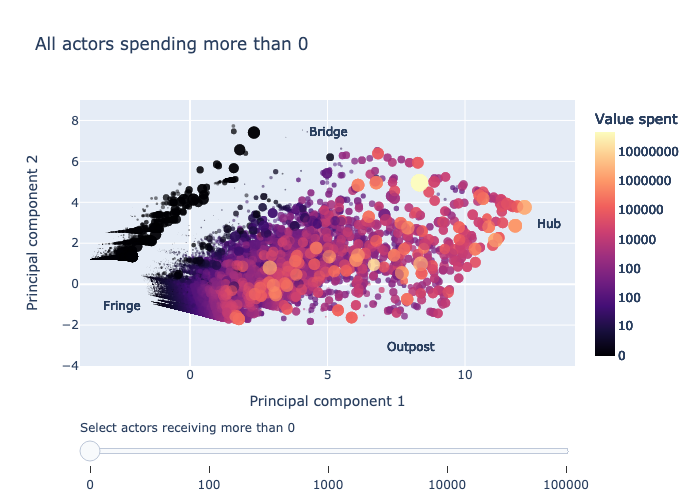

In [19]:
img_bytes = generate_filter_figure(df_out)
Image(img_bytes)

### Archetype labelling

Now that we know how various  actors will fit into the network we can try to work out where a given actor ID will fall in our parameter space. I have roughly assigned the four major corners in our PCA curve to a network archetype. Each new actor is transformed through the PCA pipeline to map it into PCA space and the nearest corner is found. 

This is kind of crude but the logic can be refined, say by defining the convex hull of the big cluster and finding distances from each edge.

In [11]:
def analyze_actors(address_list:list):
    results = pipeline.transform(dataframe.loc[address_list])
    
    # These coordinates come from our PCA
    compare_list = [[5,7], [13,3], [-1,-2], [8,-3.5]]
    archetype_map = {0: 'bridge', 1: 'hub', 2:'fringe', 3:'outpost'}

    for rp,al in zip(results, address_list):
        distlist = []
        for cp in compare_list:
            dist = (rp[0]-cp[0])**2 + (rp[0]-cp[0])**2
            distlist.append(dist)
        if np.min(distlist) < 2:
            print('%s is almost certainly a %s' % (al, archetype_map[np.argmin(distlist)]))            
        else:
            print('%s is probably a %s' % (al, archetype_map[np.argmin(distlist)]))

This is a list of actors who are known to be associated with exchange accounts. As we can see these points are all near the "hub" corner of our PCA quadrangle!

In [12]:
analyze_actors(['f047684','f034689', 'f033259', 'f033544', 'f0412624', 'f039682', 
                'f034212', 'f023933', 'f033348', 'f0130039', 'f099824'])

f047684 is almost certainly a hub
f034689 is almost certainly a hub
f033259 is almost certainly a hub
f033544 is almost certainly a hub
f0412624 is almost certainly a hub
f039682 is almost certainly a hub
f034212 is almost certainly a hub
f023933 is almost certainly a hub
f033348 is almost certainly a hub
f0130039 is almost certainly a hub
f099824 is almost certainly a hub


### Adding selected actors to our Plotly

It is also instructive to see where the selected actors end up in PCA space, and also get some information about their size. 

In [13]:
def generate_comparison_figure(dataframe:pd.DataFrame, selected_actors:list, n_samples=30000):

    dfc = dataframe.sample(n_samples)
    dx = pipeline.transform(dfc)
    df_out = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
    df_out['PC1'] = dx[:,0]
    df_out['PC2'] = dx[:,1]
    df_out['value_spent_rd'] = np.round(df_out['value_spent'],0)
    df_out['value_received_rd'] = np.round(df_out['value_received'],0)
    df_out['log1p_spent'] = np.log1p(df_out['value_spent'])
    df_out['log1p_received'] = np.log1p(df_out['value_received'])
    df_out['in_centrality_quartile'] = pd.qcut(df_out['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
    df_out['out_centrality_quartile'] = pd.qcut(df_out['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})

    dfc = dataframe.loc[selected_actors]
    dx = pipeline.transform(dfc)
    df_out2 = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
    df_out2['PC1'] = dx[:,0]
    df_out2['PC2'] = dx[:,1]
    df_out2['value_spent_rd'] = np.round(df_out2['value_spent'],0)
    df_out2['value_received_rd'] = np.round(df_out2['value_received'],0)
    df_out2['log1p_spent'] = np.log1p(df_out2['value_spent'])
    df_out2['log1p_received'] = np.log1p(df_out2['value_received'])
    df_out2['in_centrality_quartile'] = pd.qcut(df_out2['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
    df_out2['out_centrality_quartile'] = pd.qcut(df_out2['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})    

    fig = go.Figure() 
    fig.add_trace(    
        go.Scatter(x = df_out[df_out.PC1 > 8]['PC1'], 
                   y = df_out[df_out.PC1 > 8]['PC2'],
                   mode = 'markers', 
                   name='Original',
                   customdata=df_out[df_out.PC1 > 8][df_out.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=0),
                       size=df_out[df_out.PC1 > 8]['log1p_received']
                   )               
                )
    )

    fig.add_trace(    
        go.Scatter(x = df_out2['PC1'], 
                   y = df_out2['PC2'],
                   mode = 'markers', 
                   name = 'Selected actors',
                   customdata=df_out2[df_out2.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=0, color='red'),
                       color='red',
                       size=df_out2['log1p_received']
                   )               
                )
    )


    fig.update_traces(hovertemplate='<b>Address ID</b> %{customdata[0]}<br>' +
                                    '<b>Neighbors</b> %{customdata[1]}<br>' +
                                    '<b>Spent</b> %{customdata[2]}<br>' +
                                    '<b>Received</b> %{customdata[3]}<br>' +  
                                    '<b>In-centrality</b> %{customdata[4]}<br>' +  
                                    '<b>Out-centrality</b> %{customdata[5]}<br>' +                    
                                    '<extra></extra>',\
                      selector=dict(type='scatter')) 
    fig.update_layout(title_text='PCA analysis of token flow', 
                      xaxis_title='Principal component 1',
                      yaxis_title='Principal component 2')

    fig.add_annotation(x=13, y=3,ax=1,ay=1, text="Hub")
    fig.add_annotation(x=8, y=-3,ax=1,ay=1, text="Outpost")
    fig.show()
    return fig.to_image(format="png")
#     Image(img_bytes)

In [14]:
selected_actors = ['f036150', #bitfinex
                   'f084877', 'f0227189', 'f0227195', # coinbase
                   'f034689', #gate
                   'f033259', #huobi
                   'f033544', #kraken
                   'f042593',  #kucoin
                   'f047684',  #oke
                   'f0412624', 'f039682', 'f023933', 'f033348', 'f0130039', 'f099824'
                  ]
fig_out = generate_comparison_figure(dataframe, selected_actors)

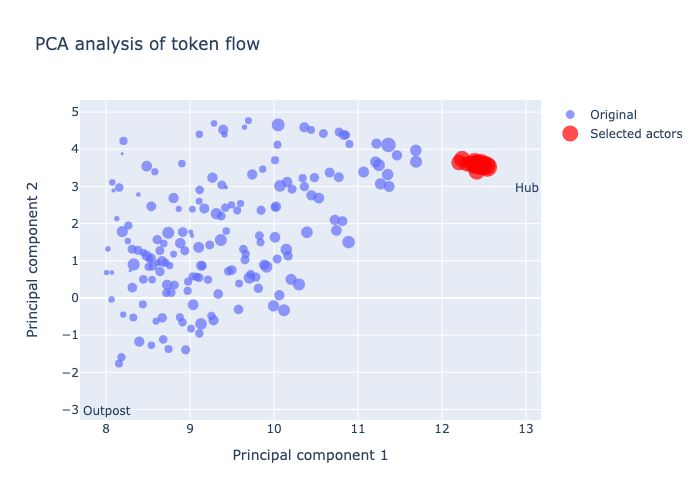

In [15]:
Image(fig_out)

### Plot all known archetypes

In [16]:
def generate_archetype_figure(generate_figure=True):

    dfc = dataframe.sample(30000)
    dx = pipeline.transform(dfc)
    df_out = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
    df_out['PC1'] = dx[:,0]
    df_out['PC2'] = dx[:,1]
    df_out['value_spent_rd'] = np.round(df_out['value_spent'],0)
    df_out['value_received_rd'] = np.round(df_out['value_received'],0)
    df_out['log1p_spent'] = np.log1p(df_out['value_spent'])
    df_out['log1p_received'] = np.log1p(df_out['value_received'])
    df_out['in_centrality_quartile'] = pd.qcut(df_out['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
    df_out['out_centrality_quartile'] = pd.qcut(df_out['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})


    fig = go.Figure() 
    fig.add_trace(    
        go.Scatter(x = df_out['PC1'], 
                   y = df_out['PC2'],
                   mode = 'markers', 
                   name='Original',
                   customdata=df_out[df_out.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=0),
                       size=0.75*df_out['log1p_received'],
                       color='rgba(0,0,0,0.5)'
                   )               
                )
    )





    miners = ['f0100027', 'f0100074', 'f010025', 'f010083', 'f0101710', 'f01017840', 'f01018842', 'f0102513', 'f01025308', 'f01026766', 'f01029529', 'f01031886', 'f0103278', 'f01032958', 'f01033275', 'f0103380', 'f01033899', 'f0103435', 'f01035845', 'f01036411', 'f01038978', 'f01039502', 'f01040287', 'f01043130', 'f01046857', 'f0104700', 'f0104772', 'f01051178', 'f01051806', 'f010532', 'f01058204', 'f01060489', 'f01061316', 'f01061522', 'f01061840', 'f01061941', 'f01063462', 'f0106593', 'f01066039', 'f01068156', 'f01068613', 'f01069400', 'f01069798', 'f01069836', 'f01070549', 'f01071189', 'f01071955', 'f01072215', 'f0107734']
    dfc = dataframe.loc[miners[0:20]]
    dx = pipeline.transform(dfc)
    df_out5 = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
    df_out5['PC1'] = dx[:,0]
    df_out5['PC2'] = dx[:,1]
    df_out5['value_spent_rd'] = np.round(df_out5['value_spent'],0)
    df_out5['value_received_rd'] = np.round(df_out5['value_received'],0)
    df_out5['log1p_spent'] = np.log1p(df_out5['value_spent'])
    df_out5['log1p_received'] = np.log1p(df_out5['value_received'])
    df_out5['in_centrality_quartile'] = pd.qcut(df_out5['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
    df_out5['out_centrality_quartile'] = pd.qcut(df_out5['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})    

    fig.add_trace(    
        go.Scatter(x = df_out5['PC1'], 
                   y = df_out5['PC2'],
                   mode = 'markers', 
                   name = 'Miners',
                   customdata=df_out5[df_out5.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=1, color='blue'),
                       color='blue',
                       size=10,
                       symbol='diamond'
                   )               
                )
    )

    clients = ['f023846', 'f058086', 'f023148', 'f01174243', 'f08395', 'f0239202', 'f016096', 'f01851817', 'f029627', 'f0117640', 'f01725224', 'f01619669', 'f01200018', 'f0111916', 'f01869738', 'f023974', 'f025018', 'f0680681', 'f0146878', 'f01198301']
    dfc = dataframe.loc[clients]
    dx = pipeline.transform(dfc)
    df_out6 = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
    df_out6['PC1'] = dx[:,0]
    df_out6['PC2'] = dx[:,1]
    df_out6['value_spent_rd'] = np.round(df_out6['value_spent'],0)
    df_out6['value_received_rd'] = np.round(df_out6['value_received'],0)
    df_out6['log1p_spent'] = np.log1p(df_out6['value_spent'])
    df_out6['log1p_received'] = np.log1p(df_out6['value_received'])
    df_out6['in_centrality_quartile'] = pd.qcut(df_out6['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
    df_out6['out_centrality_quartile'] = pd.qcut(df_out6['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})    

    fig.add_trace(    
        go.Scatter(x = df_out6['PC1'], 
                   y = df_out6['PC2'],
                   mode = 'markers', 
                   name = 'Clients',
                   customdata=df_out6[df_out6.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=1, color='yellow'),
                       color='yellow',
                       size=10,
                       symbol='square'
                   )               
                )
    )

    blackhole = ['f01356941', 'f01036408', 'f034259', 'f035284', 'f023933', 'f099824', 'f0217357', 'f0412624', 'f0102227', 'f033348', 'f080073', 'f01040440', 'f01051832', 'f080030', 'f0100126', 'f01906216', 'f0100126', 'f0412624', 'f01906216', 'f034259']
    dfc = dataframe.loc[blackhole]
    dx = pipeline.transform(dfc)
    df_out4 = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
    df_out4['PC1'] = dx[:,0]
    df_out4['PC2'] = dx[:,1]
    df_out4['value_spent_rd'] = np.round(df_out4['value_spent'],0)
    df_out4['value_received_rd'] = np.round(df_out4['value_received'],0)
    df_out4['log1p_spent'] = np.log1p(df_out4['value_spent'])
    df_out4['log1p_received'] = np.log1p(df_out4['value_received'])
    df_out4['in_centrality_quartile'] = pd.qcut(df_out4['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
    df_out4['out_centrality_quartile'] = pd.qcut(df_out4['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})    

    fig.add_trace(    
        go.Scatter(x = df_out4['PC1'], 
                   y = df_out4['PC2'],
                   mode = 'markers', 
                   name = 'Exchange unverified',
                   customdata=df_out4[df_out4.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=0, color='red'),
                       color='purple',
                       size=10,
                       symbol='x'
                   )               
                )
    )

    reserve = ['f028890', 'f027464', 'f027875', 'f028944', 'f028628', 'f028096', 'f026882', 'f027257', 'f028437', 'f028366']
    dfc = dataframe.loc[reserve]
    dx = pipeline.transform(dfc)
    df_out3 = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
    df_out3['PC1'] = dx[:,0]
    df_out3['PC2'] = dx[:,1]
    df_out3['value_spent_rd'] = np.round(df_out3['value_spent'],0)
    df_out3['value_received_rd'] = np.round(df_out3['value_received'],0)
    df_out3['log1p_spent'] = np.log1p(df_out3['value_spent'])
    df_out3['log1p_received'] = np.log1p(df_out3['value_received'])
    df_out3['in_centrality_quartile'] = pd.qcut(df_out3['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
    df_out3['out_centrality_quartile'] = pd.qcut(df_out3['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})    

    fig.add_trace(    
        go.Scatter(x = df_out3['PC1'], 
                   y = df_out3['PC2'],
                   mode = 'markers', 
                   name = 'SAFT',
                   customdata=df_out3[df_out3.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=0, color='red'),
                       color='green',
                       size=10,
                       symbol='cross'
                   )               
                )
    )
    exchange_verified = ['f036150', #bitfinex
                       'f084877', 'f0227189', 'f0227195', # coinbase
                       'f034689', #gate
                       'f033259', #huobi
                       'f033544', #kraken
                       'f042593',  #kucoin
                       'f047684',  #oke
                       'f0412624', 'f039682', 'f023933', 'f033348', 'f0130039', 'f099824'
                      ]
    dfc = dataframe.loc[exchange_verified]
    dx = pipeline.transform(dfc)
    df_out2 = dfc.reset_index().merge(dataframe.reset_index()[['index']], how='inner', left_on='index', right_on='index')
    df_out2['PC1'] = dx[:,0]
    df_out2['PC2'] = dx[:,1]
    df_out2['value_spent_rd'] = np.round(df_out2['value_spent'],0)
    df_out2['value_received_rd'] = np.round(df_out2['value_received'],0)
    df_out2['log1p_spent'] = np.log1p(df_out2['value_spent'])
    df_out2['log1p_received'] = np.log1p(df_out2['value_received'])
    df_out2['in_centrality_quartile'] = pd.qcut(df_out2['in_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})
    df_out2['out_centrality_quartile'] = pd.qcut(df_out2['out_centrality'], 4, labels=False, duplicates='drop').map({3:'High', 2:'High', 1:'Medium', 0:'Low'})    

    fig.add_trace(    
        go.Scatter(x = df_out2['PC1'], 
                   y = df_out2['PC2'],
                   mode = 'markers', 
                   name = 'Exchange verified',
                   customdata=df_out2[df_out2.columns[[0,1,11,12,15,16]]],
                   marker=dict(
                       line=dict(width=0, color='red'),
                       color='red',
                       size=10,
                       symbol='star-diamond'
                   )               
                )
    )
    fig.update_traces(hovertemplate='<b>Address ID</b> %{customdata[0]}<br>' +
                                    '<b>Neighbors</b> %{customdata[1]}<br>' +
                                    '<b>Spent</b> %{customdata[2]}<br>' +
                                    '<b>Received</b> %{customdata[3]}<br>' +  
                                    '<b>In-centrality</b> %{customdata[4]}<br>' +  
                                    '<b>Out-centrality</b> %{customdata[5]}<br>' +                    
                                    '<extra></extra>',\
                      selector=dict(type='scatter')) 
    fig.update_layout(title_text='Archetypes in PCA space', 
                      xaxis_title='Principal component 1',
                      yaxis_title='Principal component 2')

    fig.add_annotation(x=0, y=5, text="Net receivers of token")
    fig.add_annotation(x=5, y=7.5, ax=1,ay=1,text="Bridge")
    fig.add_annotation(x=13, y=3,ax=1,ay=1, text="Hub")
    fig.add_annotation(x=-2.5, y=-1, ax=1,ay=1, text="Fringe")
    fig.add_annotation(x=8, y=-3,ax=1,ay=1, text="Outpost")
    fig.show()
    
    if generate_figure:
        fig.write_html("archetype_all.html")
        
    return fig.to_image(format="png")


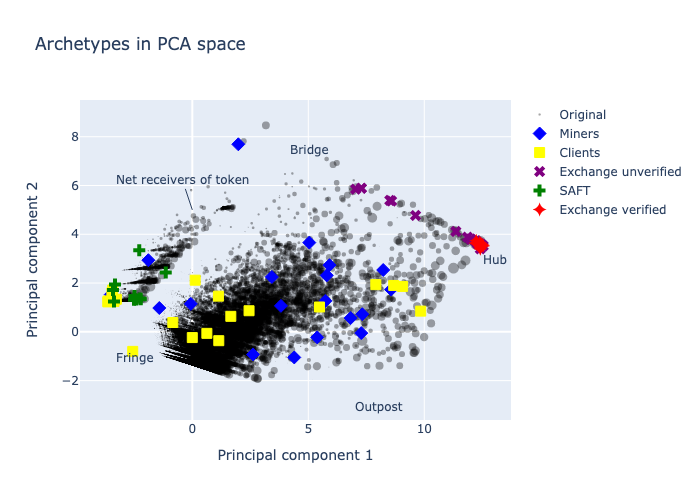

In [17]:
fig_out = generate_archetype_figure()
Image(fig_out)

Exchange actors line up the top edge of our PCA space, being generally highly connected and loaded with token, while the most established or known exchanges appear at the rightmost point of the PCA quadrangle. The graveyard on the left is reserved for Simple Agreement for Future Token contracts. Note that the centre of gravity of the PCA space is close to the fringe, meaning that most individual actors have little value and not particularly influential. 